In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch

import scipy
import skimage
from skimage.transform import rescale, resize, downscale_local_mean

import sys
sys.path.append('..')
from core.samplers_torch import DGibbsBatch, GibbsBatch
from core.distributions_torch import Discrete2DBatch

In [3]:
class Independent2D:
    def __init__(self, probs, batch_size):
        self.probs = probs
        self.h, self.w = probs.shape
        self.device = probs.device
        self.batch_size = batch_size
        self.dims = torch.tensor([self.h, self.w]).long().to(self.device)
        self.dist = torch.distributions.categorical.Categorical(probs.flatten())
        self.samples = []
        self.weights = []
        
    def iterate(self):
        sample = self.dist.sample((batch_size,))
        state = torch.stack([sample // probs.shape[1], sample % probs.shape[1]]).T
        self.samples.append(state)
        self.weights.append(torch.ones(batch_size))
        
def sample(sampler, n):
    for _ in range(int(n)):
        sampler.iterate()

def get_hist(sampler, batch_id):
    samples = torch.stack(sampler.samples)[:,batch_id,:].cpu().numpy()
    weights = torch.stack(sampler.weights)[:,batch_id].cpu().numpy()
    weights /= np.sum(weights)
    approx_hist, grid_x, grid_y = np.histogram2d(samples[:,0], samples[:,1], 
                                                 bins=probs.shape, weights=weights)
    return approx_hist

### target distribution

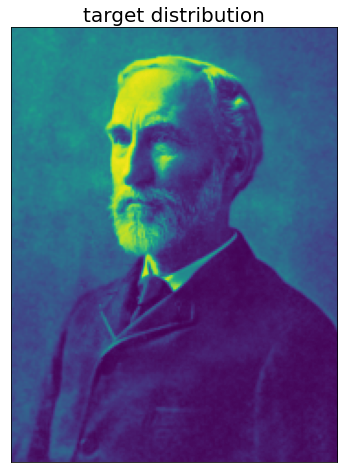

In [21]:
img = matplotlib.image.imread('../data/portrait.jpg')
img = rescale(img, 0.2)
img = np.sum(img, axis=2)
img = img/np.sum(img)
figsize(8,8)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('target distribution', fontsize=20)
plt.savefig('portrait_target.pdf', bbox_inches='tight')
plt.show()

In [5]:
device = torch.device('cpu')
batch_size = 100
num_samples = 2*10**5

probs = torch.tensor(img).to(device)
target_gibbs_d = Discrete2DBatch(probs.clone())
target_gibbs_d.init_random(batch_size)
target_gibbs = Discrete2DBatch(probs.clone())
target_gibbs.init_random(batch_size)
target_suzuki = Discrete2DBatch(probs.clone())
target_suzuki.init_random(batch_size)

gibbs_d = DGibbsBatch(target_gibbs_d, v_coeffs=torch.tensor([np.sqrt(2),1.0]))
suzuki = DGibbsBatch(target_suzuki)
gibbs = GibbsBatch(target_gibbs)
independent = Independent2D(probs, batch_size)

In [6]:
sample(gibbs_d, num_samples)
sample(independent, num_samples)
sample(gibbs, num_samples)
sample(suzuki, num_samples)

In [9]:
hist_gibbs_d = get_hist(gibbs_d,0)
hist_ind = get_hist(independent,0)
hist_gibbs = get_hist(gibbs,0)
hist_suzuki = get_hist(suzuki,0)

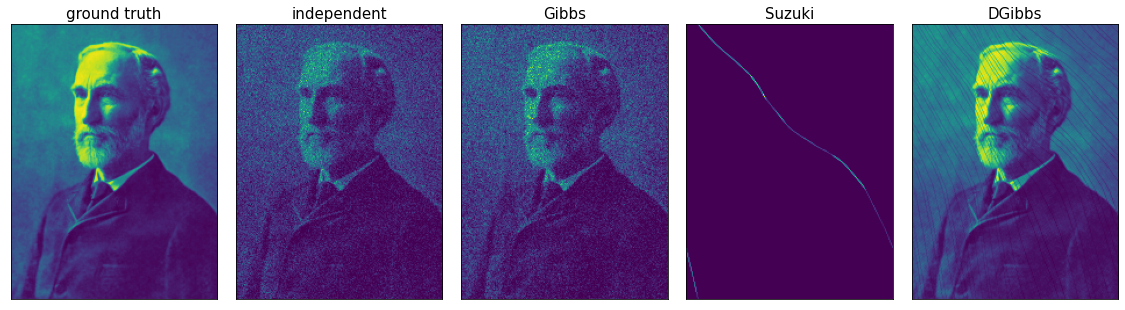

In [18]:
figsize(16,6)
plt.subplot(151)
plt.tight_layout()
plt.imshow(probs.cpu().numpy())
plt.xticks([])
plt.yticks([])
plt.title('ground truth', fontsize=15)
plt.subplot(152)
plt.imshow(hist_ind)
plt.xticks([])
plt.yticks([])
plt.title('independent', fontsize=15)
plt.subplot(153)
plt.imshow(hist_gibbs)
plt.xticks([])
plt.yticks([])
plt.title('Gibbs', fontsize=15)
plt.subplot(154)
plt.imshow(hist_suzuki)
plt.xticks([])
plt.yticks([])
plt.title('Suzuki', fontsize=15)
plt.subplot(155)
plt.imshow(hist_gibbs_d)
plt.xticks([])
plt.yticks([])
plt.title('DGibbs', fontsize=15)
plt.savefig('portrait_all.pdf', bbox_inches='tight')

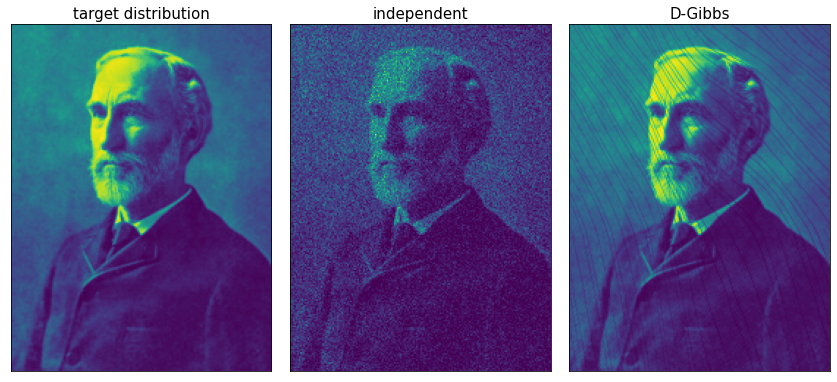

In [20]:
figsize(12,6)
plt.subplot(131)
plt.tight_layout()
plt.imshow(probs.cpu().numpy())
plt.xticks([])
plt.yticks([])
plt.title('target distribution', fontsize=15)
plt.subplot(132)
plt.imshow(hist_ind)
plt.xticks([])
plt.yticks([])
plt.title('independent', fontsize=15)
plt.subplot(133)
plt.imshow(hist_gibbs_d)
plt.xticks([])
plt.yticks([])
plt.title('D-Gibbs', fontsize=15)
plt.savefig('portrait.pdf', bbox_inches='tight')

In [12]:
def get_errors(sampler, true_mean, iteration_grid, batch_size):
    errors = np.zeros([len(iteration_grid), batch_size])
    samples = torch.stack(sampler.samples).cpu().numpy()
    weights = torch.stack(sampler.weights).cpu().numpy()
    for i in range(len(iteration_grid)):
        n = iteration_grid[i]
        samples_cur = samples[:n,:,:]
        weights_cur = weights[:n,:,np.newaxis]
        means = np.sum(samples_cur*weights_cur, axis=0)/np.sum(weights_cur, axis=0)
        errors[i,:] = np.sqrt(np.sum((means-true_mean[np.newaxis,:])**2, axis=1))
    return errors

def get_true_mean(probs):
    x,y = np.meshgrid(np.arange(probs.shape[0]), np.arange(probs.shape[1]))
    coords = np.stack([x.T,y.T], axis=2)
    return np.sum(np.sum(probs[:,:,np.newaxis]*coords, axis=0), axis=0)

def plot_errors(errors, n_iterations, label):
    errors_sorted = np.sort(errors, axis=0)
    plt.plot(n_iterations, np.mean(errors, axis=0), lw=5, label=label)
    n_chains = errors.shape[0]
    plt.fill_between(n_iterations, errors_sorted[int(n_chains*0.1),:], 
                     errors_sorted[int(n_chains*0.9),:], alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('number of samples', fontsize=25)
    plt.ylabel('absolute error', fontsize=25)

In [13]:
iteration_grid = np.unique(np.logspace(0,5,30, dtype=int))
iteration_grid = np.hstack([iteration_grid,num_samples])

true_mean = get_true_mean(probs.cpu().numpy())
errors_gibbs_d = get_errors(gibbs_d, true_mean, iteration_grid, batch_size)
errors_gibbs = get_errors(gibbs, true_mean, iteration_grid, batch_size)
errors_ind = get_errors(independent, true_mean, iteration_grid, batch_size)

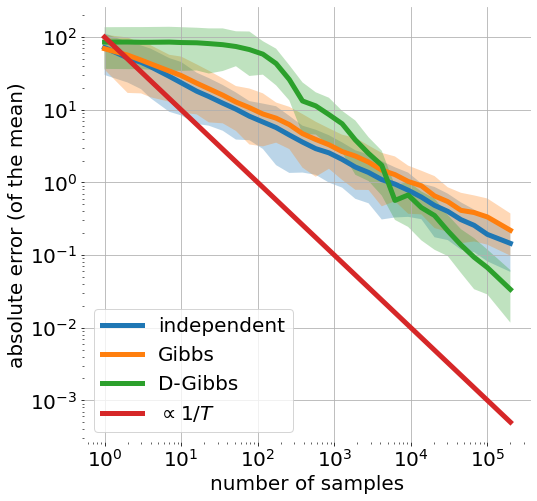

In [16]:
figsize(8,8)
plot_errors(errors_ind.T, iteration_grid, 'independent')
plot_errors(errors_gibbs.T, iteration_grid, 'Gibbs')
plot_errors(errors_gibbs_d.T, iteration_grid, 'D-Gibbs')
plt.plot(iteration_grid,100/iteration_grid, label=r'$\propto1/T$', lw=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of samples', size=20)
plt.ylabel('absolute error (of the mean)', size=20)
plt.legend(fontsize=20)
plt.grid()
plt.box(False)
plt.savefig('portrait_asymptotics.pdf', bbox_inches='tight')

In [6]:
device = torch.device('cuda:0')
batch_size = 1000
num_samples = 2*10**5

probs = torch.tensor(img).to(device)
target_gibbs = distributions.Discrete2DBatch(probs.clone())
target_suzuki = distributions.Discrete2DBatch(probs.clone())
target_gibbs.init_random(batch_size)
target_suzuki.init_random(batch_size)

gibbs = samplers.GibbsBatch(target_gibbs)
suzuki = samplers.DGibbsBatch(target_suzuki)

In [7]:
sample(gibbs, num_samples)
sample(suzuki, num_samples)

In [9]:
hist_suzuki = get_hist(suzuki,0)
hist_gibbs = get_hist(gibbs,0)

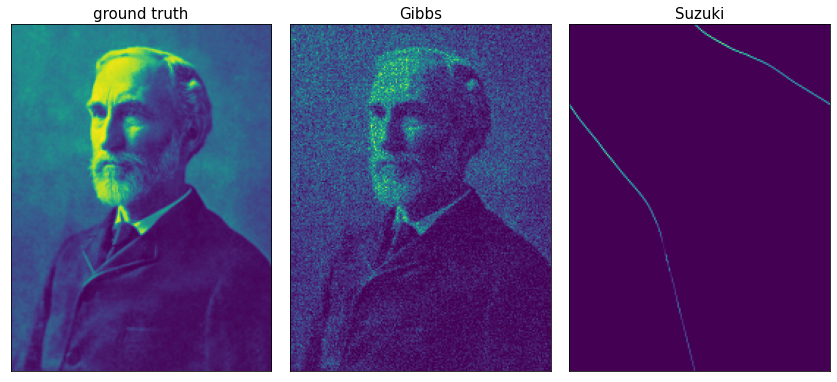

In [12]:
figsize(12,6)
plt.subplot(131)
plt.tight_layout()
plt.imshow(probs.cpu().numpy())
plt.xticks([])
plt.yticks([])
plt.title('ground truth', fontsize=15)
plt.subplot(132)
plt.imshow(hist_gibbs)
plt.xticks([])
plt.yticks([])
plt.title('Gibbs', fontsize=15)
plt.subplot(133)
plt.imshow(hist_suzuki)
plt.xticks([])
plt.yticks([])
plt.title('Suzuki', fontsize=15)
plt.show()